In [1]:
%matplotlib inline

In [2]:
import os
from pathlib import Path

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('figure', figsize=(6, 4.5))
mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = '0.25'

import xarray as xr
import xgcm

from scipy.special import erf
from numpy import pi as π

In [3]:
# trig functions that take degrees

def sind(x):
    return np.sin(np.deg2rad(x))

def cosd(x):
    return np.cos(np.deg2rad(x))

## Constants

In [4]:
ρ0 = 1035 # Boussinesq reference density
g = 9.8
Ω = 7.29e-5
a = 6370e3

# Make input directory

In [13]:
# Path('./INPUT').mkdir(exist_ok=True)

# Create grid

An isotropic grid has $\Delta x = \Delta y$. In spherical coordiantes, in is $\Delta \lambda \cos\vartheta = \Delta \vartheta$. We can convert this into a useful ODE by parameterizing $\vartheta$ by $j$, which takes on integer values for $q$ points and half-integer values for $h$ points. The differential equation is then

$$
    \frac{\mathrm{d}\vartheta}{\mathrm{d}j} = \Delta \lambda \cos\vartheta.
$$

The solution to this is

$$
    \vartheta = 2\arctan c_1 e^{j\Delta \lambda} - \frac{\pi}{2}.
$$

We can determine constant by requiring that $\vartheta(0) = \vartheta_s$. The result is

$$
    \vartheta = -\frac{\pi}{2} + 2\arctan \left[\tan\left(\frac{\vartheta_s}{2} + \frac{\pi}{4}\right) e^{j\Delta \lambda}\right].
$$

The number of grid points is determined by requiring $\vartheta(J) = \vartheta_n$. This gives

$$
    J \Delta \lambda = \log \tan \left(\frac{\vartheta_n}{2} + \frac{\pi}{4}\right) - \log \tan \left(\frac{\vartheta_s}{2} + \frac{\pi}{4}\right).
$$

Since $J$ must be an integer, this means that the northern boundary might not be exactly at $\vartheta_n$. If we'd rather have exact control over the domain width while being a little looser about the grid spacing, we can instead let $\Delta \lambda$ be determined by needing to fit the northern boundary:

$$
    \vartheta = -\frac{\pi}{2} + 2\arctan\left[\tan^{1-j/J}\left(\frac{\vartheta_s}{2} + \frac{\pi}{4}\right)\tan^{j/J}\left(\frac{\vartheta_n}{2} + \frac{\pi}{4}\right)\right].
$$

We'd still want to use the second to last expression above to get an guess for the correct value of $J$.

In [31]:
grid = 'isotropic'

points_per_degree = 16

a = 6370e3
λw = 0
λe = 30
θs = 10
θn = 45
Δλ = 1/points_per_degree

xq = np.arange(λw,      λe+Δλ, Δλ)
xh = np.arange(λw+Δλ/2, λe,    Δλ)

NX = len(xh)

if grid == 'latlon':
    Δθ = Δλ

    yq = np.arange(θs,      θn+Δθ, dθ)
    yh = np.arange(θs+Δθ/2, θn,    dθ)
    NY = len(yh)
elif grid == 'isotropic': # aka Mercator
    tanS = np.tan(np.radians(θs)/2 + π/4)
    tanN = np.tan(np.radians(θn)/2 + π/4)
    
    NY = np.ceil(np.log(tanN/tanS)/np.radians(Δλ))
    
    jh = np.arange(NY) + .5
    jq = np.arange(NY+1)

    yq = np.degrees(-π/2 + 2*np.arctan(tanS**(1-jq/NY)*tanN**(jq/NY)))
    yh = np.degrees(-π/2 + 2*np.arctan(tanS**(1-jh/NY)*tanN**(jh/NY)))
    
    # yq = np.rad2deg(2*np.arctan(np.exp(jq*np.deg2rad(dx))*np.tan(π/4 + np.deg2rad(ys)/2)) - π/2)
    # yh = np.rad2deg(2*np.arctan(np.exp(jh*np.deg2rad(dx))*np.tan(π/4 + np.deg2rad(ys)/2)) - π/2)
else:
    RuntimeError('unknown grid type')

print('NY = ', NY)
    
dyq = a*np.radians(np.diff(yh))
dyh = a*np.radians(np.diff(yq))
dxq = a*np.radians(Δλ)*cosd(yq)
dxh = a*np.radians(Δλ)*cosd(yh)

Aq = dxq[1:-1]*dyq

NY =  648.0


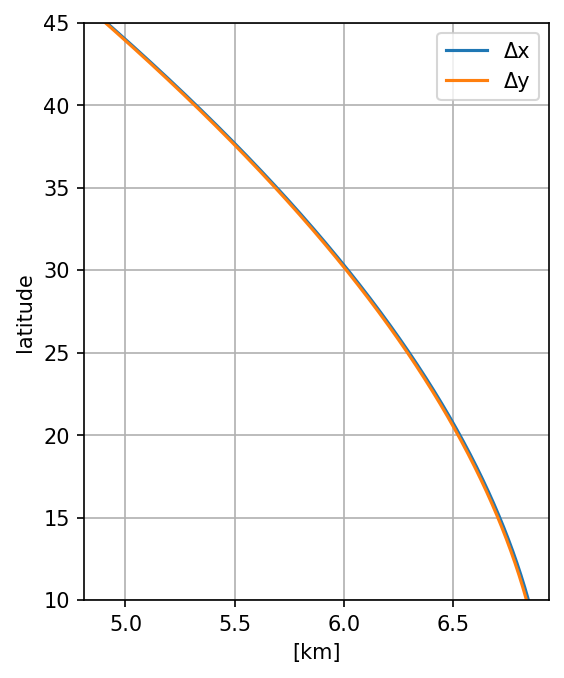

In [32]:
fig, ax = plt.subplots(figsize=(4,5))

ax.plot(dxh/1e3, yh, label='Δx')
ax.plot(dyh/1e3, yh, label='Δy')
ax.legend()
ax.set_ylim(θs, θn)
ax.set_xlabel('[km]')
ax.set_ylabel('latitude')
ax.grid()

# Layer configuration

The wave speeds for a 3-layer fluid with a rigid lid are

$$
    c^2 = \frac{1}{2H}\left[g_1'H_1(H-H1) + g_2'(H-H_1 - H_2)(H_1+H_2) \pm \sqrt{[g_1'H_1(H-H_1) - g_2'(H-H_1-H_2)(H_1 + H_2)]^2 + 4g_1' g_2' H_1^2 (H-H_1 - H_2)^2}\right].
$$

If we restrict our attention to the case where $g_1' = g_2' = g'$ and define $H_2 = (r-1)H_1$ and $H = H1 H'$, this becomes

$$
    c^2 = \frac{g' H_1}{2H'}\left[(1+r)H' - 1 - r^2 \pm \sqrt{(1+r^2)^2 - 2 H'(1+3r-r^2+r^3 + H'^2(5-2r-r^2))}\right].
$$

For Cessi's (1990) values of $r = 3$ and $H' = 16$, this is

$$
    c^2 = \frac{54 \pm 2\sqrt{313}}{32}g' H_1.
$$

If $H = 4000$ m, this gives $H_1 = 250$ and $H_2 = 500$. Picking the deformation radius $L_1 = 45$ km at 30º determines the reduced gravity to be

$$
    g' = \frac{32 f^2 L_1^2}{(54 + 2\sqrt{313})H_1} = 0.0154\text{ m s$^{-2}$}.
$$

Then, the two deformation radii are $L_1 = 45$ km and $L_2 = 20.5$ km.

In [15]:
Ω = 7.29e-5
f = 2*Ω*sind(30)

H = 4000
H1 = 250
H2 = 500
H3 = H - H1 - H2
H2 = H - H1
gp = 0.0154

In [16]:
# number of layers
NK = 3

# With (η1, η2) = (-250, -750), the depths in the SW corner were (-328, -750) and the EB depths were (-243, -750)
# With (η1, η2) = (-175, -750), the depths in the SW corner were (-272, -749) and the EB depths were (-154, -749)

# interface depths
eta = np.array([
       0,
    -175,
    -750,
  -12000, # the last entry can be anything as long as it's deeper than the basin
], dtype=float) 

interface_IC = xr.Dataset(
    {'eta': (['nki'], eta, {'long_name': 'Initial depth of interfaces', 'units': 'meters'})},
)

interface_IC.to_netcdf('INPUT/interface_IC.nc')

In [17]:
interface_IC

<xarray.Dataset>
Dimensions:  (nki: 4)
Dimensions without coordinates: nki
Data variables:
    eta      (nki) float64 0.0 -175.0 -750.0 -1.2e+04

# Topography - Erf-like shelves on eastern and western boundaries

## Case II: constant width in kilometers - this is what we use

In [18]:
geolon, geolat = np.meshgrid(xh, yh)

x = a*np.deg2rad(geolon)*cosd(geolat)
λe = 30 # longitude of eastern boundary
Lx = a*np.deg2rad(λe)*cosd(geolat) # width of basin

Hshelf = 100 # shelf depth
Hmax = 4000

Lshelf = 150 # shelf width in kilometers
Lslope = 150 # slope width in kilometers

def H0(x):
    return 0.5*(Hmax - Hshelf)*(1 - erf(np.sqrt(π)*((x/1e3 - Lshelf)/Lslope - 0.5)))

H = Hmax - H0(x) - H0(Lx-x)

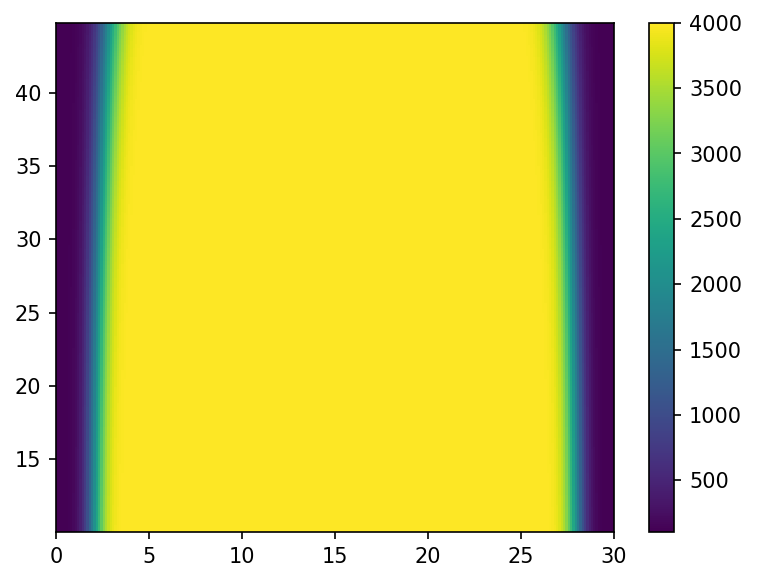

In [19]:
plt.pcolormesh(geolon, geolat, H, shading='auto')
plt.colorbar()

In [20]:
topog = xr.Dataset(coords={'yh': (['yh'], yh), 'xh': (['xh'], xh)})

topog['depth'] = (['yh', 'xh'], H, {'long_name': 'Ocean Depth', 'units': 'm'})

topog.to_netcdf('INPUT/topog_degrees.nc')

topog

<xarray.Dataset>
Dimensions:  (yh: 321, xh: 240)
Coordinates:
  * yh       (yh) float64 10.06 10.18 10.31 10.43 ... 44.46 44.55 44.64 44.73
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 29.69 29.81 29.94
Data variables:
    depth    (yh, xh) float64 100.5 101.2 102.8 106.0 ... 101.6 100.9 100.5

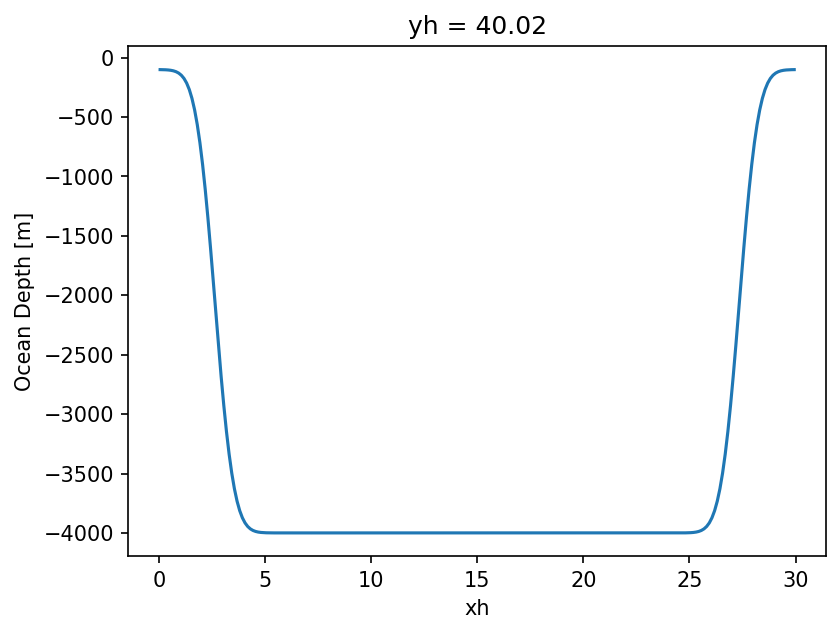

In [21]:
(-topog.depth).sel(yh=40, method='nearest').plot()

# Wind forcing

## Simple curl

The wind forcing is the same as in the Parsons-Veronis notebook.

In [22]:
T0 = 20e6
ρ0 = 1035 # Boussinesq reference density
Ω = 7.29e-5
a = 6370e3

lonE = 30 # eastern boundary
λe = np.deg2rad(lonE)

V0 = T0/(a*λe*cosd(25))

def tau(θ, derivative=False):
    if derivative:
        return -(V0*Ω/(1386*np.cos(θ)**2))*np.piecewise(θ, 
                    [θ > np.deg2rad(15), θ <= np.deg2rad(15)],
                    [lambda θ: 315*np.sin(12*θ + π/4) + 994*np.sin(10*θ + π/4) + 1067*np.sin(8*θ + π/4) + 396*np.sin(6*θ + π/4) + 36*np.sin(θ), 
                     lambda θ: (190 + 81*np.sqrt(3))*np.sin(θ)])
    else:
        return (V0*Ω/(1386*np.cos(θ)))*np.piecewise(θ, 
                    [θ > np.deg2rad(15), θ <= np.deg2rad(15)],
                    [lambda θ: 63*np.cos(11*θ + π/4) + 154*np.cos(9*θ + π/4) + 99*np.cos(7*θ + π/4) - 36, 
                     lambda θ: -190 - 81*np.sqrt(3) ])


taux = ρ0*np.repeat(tau(np.deg2rad(yh))[:,np.newaxis], NX+1, axis=1)
tauy = np.zeros((NY+1, NX))



In [23]:
f = 2*Ω*sind(yh)
fq = 2*Ω*sind(yq)
β = 2*Ω*cosd(yh)/a
βq = 2*Ω*cosd(yq)/a
Lxh = a*np.deg2rad(xe-xw)*cosd(yh)
Lxq = a*np.deg2rad(xe-xw)*cosd(yq)


# net Ekman transport
Vek = -Lxh*tau(np.deg2rad(yh))/f

# Sverdrup transport
wsc = -np.diff(dxh*tau(np.deg2rad(yh)))/Aq
Vsv = (Lxq/βq)[1:-1]*wsc

# net geostrophic transport
wEk = -np.diff(dxh*tau(np.deg2rad(yh))/f)/Aq
Vg = (Lxq*fq/βq)[1:-1]*wEk

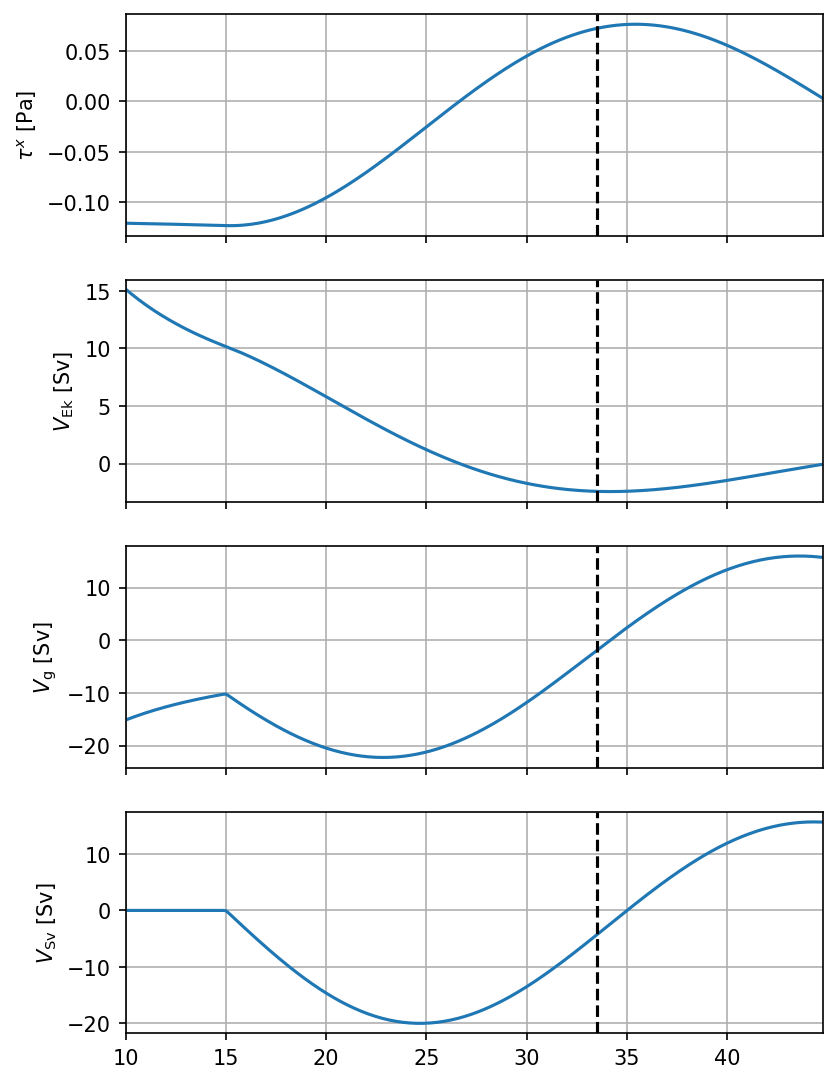

In [24]:
fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(6, 9))

ax = axs[0]
ax.plot(yh, taux[:,0])
ax.set_ylabel(r'$\tau^x$ [Pa]')

ax = axs[1]
ax.plot(yh, Vek/1e6)
ax.set_ylabel(r'$V_\mathrm{Ek}$ [Sv]')

ax = axs[2]
ax.plot(yq[1:-1], Vg/1e6, '-')
ax.set_ylabel(r'$V_\mathrm{g}$ [Sv]')

ax = axs[3]
ax.plot(yq[1:-1], Vsv/1e6)
ax.set_ylabel(r'$V_\mathrm{Sv}$ [Sv]')

ax.set_xlim([yq[0], yq[-1]])

for ax in axs:
    ax.axvline(33.5, ls='--', color='k')
    ax.grid()

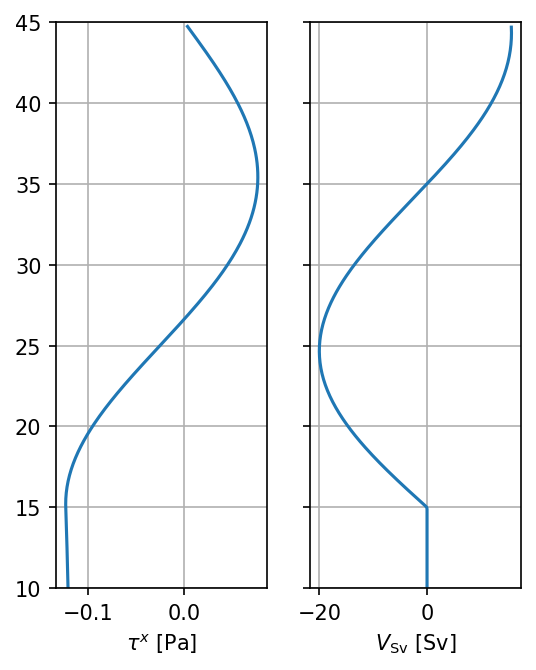

In [33]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(4, 5))

ax = axs[0]
ax.plot(taux[:,0], yh)
ax.set_xlabel(r'$\tau^x$ [Pa]')

ax = axs[1]
ax.plot(Vsv/1e6, yq[1:-1])
ax.set_xlabel(r'$V_\mathrm{Sv}$ [Sv]')

ax.set_ylim([10, 45])

for ax in axs:
    # ax.axhline(33.5, ls='--', color='k')
    ax.grid()
    
fig.savefig('wind.pdf', bbox_inches='tight')

In [16]:
# MOM6 expects xq and yq to have be missing the last point
forcing = xr.Dataset(coords={
    'yh': (['yh'], yh), 
    'xh': (['xh'], xh),
    'yq': (['yq'], yq[:-1]), 
    'xq': (['xq'], xq[:-1]),
})

forcing['STRESS_X'] = (['yh', 'xq'], taux[:,:-1], {'long_name': 'Zonal Momentum Flux', 'units': 'Pa'})
forcing['STRESS_Y'] = (['yq', 'xh'], tauy[:-1,:], {'long_name': 'Meridional Momentum Flux', 'units': 'Pa'})

forcing.to_netcdf('INPUT/forcing.nc')

forcing

<xarray.Dataset>
Dimensions:   (yh: 321, xh: 240, yq: 321, xq: 240)
Coordinates:
  * yh        (yh) float64 10.06 10.18 10.31 10.43 ... 44.46 44.55 44.64 44.73
  * xh        (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 29.69 29.81 29.94
  * yq        (yq) float64 10.0 10.12 10.25 10.37 ... 44.42 44.5 44.59 44.68
  * xq        (xq) float64 0.0 0.125 0.25 0.375 0.5 ... 29.5 29.62 29.75 29.88
Data variables:
    STRESS_X  (yh, xq) float64 -0.1208 -0.1208 -0.1208 ... 0.003364 0.003364
    STRESS_Y  (yq, xh) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0